# Testes com Filtros

Antes de colocar os filtros no projeto, quero criar e implementar alguns filtros em sinais aleatórios, em grafos aleatórios.

## Imports

In [1]:
pip install pygsp

Defaulting to user installation because normal site-packages is not writeable
                                              0.0/1.8 MB ? eta -:--:--
     ------                                   0.3/1.8 MB 6.0 MB/s eta 0:00:01
     ---------------                          0.7/1.8 MB 7.6 MB/s eta 0:00:01
     --------------------------               1.2/1.8 MB 8.6 MB/s eta 0:00:01
     ---------------------------------------  1.8/1.8 MB 9.7 MB/s eta 0:00:01
     ---------------------------------------- 1.8/1.8 MB 8.3 MB/s eta 0:00:00
                                              0.0/15.8 MB ? eta -:--:--
     -                                        0.5/15.8 MB 14.9 MB/s eta 0:00:02
     --                                       1.0/15.8 MB 12.9 MB/s eta 0:00:02
     ---                                      1.5/15.8 MB 12.3 MB/s eta 0:00:02
     -----                                    2.1/15.8 MB 12.3 MB/s eta 0:00:02
     ------                                   2.7/15.8 MB 12.2 MB/s e


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from pygsp import graphs, filters # tinha mais um comando mas n lembro agr 

## Definindo Filtros

Cada função `h` de filtros deve atuar em cima da matriz diagonal onde os valores são os autovalores do Laplaciano (ou Laplaciano normalizado).

In [4]:
def heat(lam,tau=1):
    '''Calcula a função do filtro a partir de um vetor de autovalores.
    
    Parâmetros:
    - lambda (array) - vetor de autovalores
    
    Return:
    - H (array) - matriz diagonal cujos calores da diagonal são os h(lambda_i) e
    h() é a função que define o filtro
    '''
    # primeiro definir a função 
    def h(x,tau = tau):
        return np.exp(- tau * x)
    
    h_lambda = h(lam,tau)
    H = np.diag(h_lambda)

    return H


In [5]:
heat(np.array([1,2,3]),0.5) #ok

array([[0.60653066, 0.        , 0.        ],
       [0.        , 0.36787944, 0.        ],
       [0.        , 0.        , 0.22313016]])

In [6]:
def tikhonov(lam,g=1):
    
    def h(x,g=g):
        return 1/(1+ g*x)
    
    h_lambda = h(lam)
    H = np.diag(h_lambda)

    return H 

In [7]:
tikhonov(np.array([1,2,3]),1)

array([[0.5       , 0.        , 0.        ],
       [0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.25      ]])

In [8]:
def passa_baixa(lam,l_max):
    '''Calcula a matriz de filtragem passa baixa, isto é, 
    mantém os autovalores até um certo valor l_max e depois 
    faz todos zero.
    
    Parâmetros:
    - lam (array): vetor com os autovalores
    - l_max (float): frequência/autovalor máximo permitido no filtro
    
    Return:
    - H (array): matriz diagonal onde as entradas são h(lambda)'''
    h_lambda = []
    for y in lam:
        if y > l_max:
            h_lambda.append(0)
        else:
            h_lambda.append(y)

    H = np.diag(h_lambda)
    return H 

In [9]:
passa_baixa(np.array([1,2,3]),1.5)

array([[1, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [10]:
passa_baixa(np.array([1,2,3]),2)

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 0]])

In [11]:
def passa_alta(lam,l_min):
    h_lambda = []
    for y in lam:
        if y < l_min:
            h_lambda.append(0) # corta o valor 
        else:
            h_lambda.append(y)
    H = np.diag(h_lambda)
    return H 

In [12]:
passa_alta(np.array([1,2,3]),2)

array([[0, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])

In [13]:
passa_alta(np.array([1,2,3]),2.5)

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 3]])

## Construção dos grafos 

Boa parte do projeto também depende da construção do grafo associado a imagem, então agora vou tentar implementar os dois métodos propostos. 

O primeiro consiste basicamente em conectar os pixels adjascentes, para isso preciso identificar as bordas e depois fazer as conexões corretas.

O segundo leva em consideração o gradiente de cinza da imagem (ver a ref.)

### Clássico

In [14]:
# primeiro a identificação das bordas
def bordas(img):
    '''Função que recupera os índices de cada uma das bordas de um array (ou imagem).
    
    Parâmetros:
    - img (array): matriz mxn que representa a imagem (ou qualquer outra coisa)
    
    Return:
    - left (list): índices da borda esquerda 
    - right (list): índices da borda direita
    - up (list): índices da borda superior
    - down (list): índices da borda inferior'''
    # matriz m por n 
    m, n = img.shape 

    left = [i*m for i in range(n)]
    right = [i*m - 1 for i in range(1,n+1)]
    up = [i for i in range(m)]
    down = [n*(m-1) + i for i in range(m)]

    return left, right, up, down

In [15]:
bordas(np.ones((10,10)))

([0, 10, 20, 30, 40, 50, 60, 70, 80, 90],
 [9, 19, 29, 39, 49, 59, 69, 79, 89, 99],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [16]:
def grafo_img_simples(img, adj = False, plot=True):
    '''Função que retorna uma instância do objeto graph do pygsp que
    representa uma imagem. Aqui o grafo é o mais simples possível, considerando
    adjascentes os pixels vizinhos.
       
    Parâmetros:
     - img (array): imagem a partir da qual construiremos o grafo 
     - adj (Bool): default = False, indica se retornamos ou não a matriz de adjascência
      do grafo criado 
     - plot (Bool): default = True, faz o desenho do grafo
    '''
    # primeira coisa é pegar as bordas 
    left, right, up, down = bordas(img)
    m,n = img.shape
    #W = np.zeros((m*n,m*n))
    W = []

    for i in range(m*n):
        linha = np.zeros(m*n)

        if i == 0: # canto superior esquerdo 
            linha[1] = 1 # a direita
            linha[m] = 1 # abaixo
            linha[m+1] = 1 # diagonal p baixo

        elif i == m-1: # canto superior direito
            linha[i-1] = 1 # a esquerda 
            linha[i+m] = 1 # abaixo 
            linha[i+m-1] = 1 # diagonal p baixo

        elif i == n*(m-1): # canto inferior esquerdo 
            linha[i+1] = 1 # a direita
            linha[i-m] = 1 # acima
            linha[i-m+1] = 1

        elif i == n*m -1: # canto inferior direito
            linha[i-1] = 1 # a esquerda
            linha[i-m] = 1 # acima
            linha[i-m-1] = 1

        elif i in up:
           linha[i-1] = 1
           linha[i+1] = 1
           linha[i+m] = 1
           linha[i+m-1] = 1
           linha[i+m+1] = 1
            
        elif i in left:
            linha[i+1] = 1
            linha[i-m] = 1
            linha[i+m] = 1
            linha[i-m+1] = 1
            linha[i+m+1] = 1
        
        elif i in right:
            linha[i-m] = 1
            linha[i+m] = 1
            linha[i-1] = 1
            linha[i-m-1] =1
            linha[i+m-1] = 1

        elif i in down:
            linha[i-1] - 1
            linha[i+1] = 1
            linha[i-m] = 1
            linha[i-m+1] = 1
            linha[i-m-1] = 1

        else:
            linha[i-m-1] = 1
            linha[i-m] = 1
            linha[i-m+1] = 1
            linha[i-1] = 1
            linha[i+1] = 1
            linha[i+m-1] = 1
            linha[i+m] = 1
            linha[i+m+1] = 1
        
        W.append(linha)
    W = np.array(W)
    assert W.shape == (m*n,m*n)
    
    # criando o grafo 
    G = graphs.Graph(W)
    
    if adj:
        return G, W
    elif plot:
        G.set_coordinates()
        G.plot(title=f"Grafo trivial para imagem {m}x{n}")
        return G
    else:
        return G
            
                

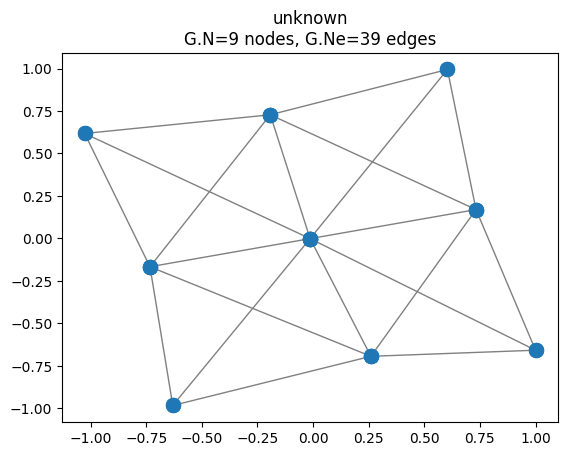

In [18]:
grafo_img_simples(np.ones((3,3)))

Com o grafo construído, os métodos e atributos do `pygsp` deveriam estar disponíveis.

In [19]:
G = grafo_img_simples(np.ones((3,3)),plot=False)
G.compute_fourier_basis()
print(G.U[0])
print(G.e)


[ 0.33333333 -0.22434757  0.54383194 -0.53268268  0.30218604  0.2731033
  0.28150813  0.00393926 -0.11785113]
[0.         2.10289945 2.26794919 2.86019037 4.64515625 5.47412021
 5.73205081 6.91763372 9.        ]


In [20]:
def autofuncoes(grafo,ret=False,plot=True):
    grafo.compute_fourier_basis()
    U = grafo.U
    lam = grafo.e
    if plot:
        fig, ax = plt.subplots(figsize=(8,6))
        n = len(lam)

        plt.plot(U + lam) #+ np.arange(n))

        ax2 = plt.twinx()
        ax2.plot(lam)
        
        ax.set_xlabel("Vértices")
        ax.set_ylabel("Valor da autofunção + autovalor")
        ax2.set_ylabel("Autovalores")
        plt.grid()
        plt.title("Autofunções")

    if ret:
        return U 


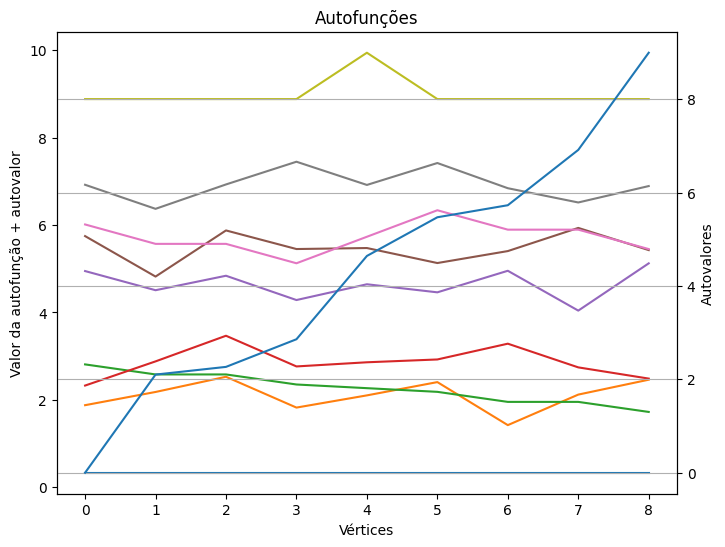

In [21]:
autofuncoes(G)

### Com pesos Gaussianos

Precisamos definir uma distância entre os vértices a ser calculada. Uma sugestão seria usar uma distância euclidiana (normalizada ou não) com as coordenadas dos pixels, ou seja, os índices dentro da matriz da imagem. 

Depois disso, conectamos os vértices com peso $$e^{- \text{dist}(i,j)^2 / 2 \theta^2}$$, para $\theta$ arbitrário, quando $\text{dist}(i,j) < \kappa$

No caso da imagem, podemos usar essa distância como a diferença na escala de cinzas entre os pixels.

In [22]:
def grafo_peso_grayscale(img,th,kap,adj=False,plot=True):
    '''Função que constrói o grafo para uma imagem em escala de cinzas
    a partir do gradiente de cor. Os pesos atribuidos a cada vértice serão
    uma gaussiana de variância theta^2 avaliada em em x = gray(i) - gray(j), 
     onde gray() é o valor na escala de cinzas de cada pixel.
      
    Parâmetros:
     - img (array): matrix representando a imagem, suas entradas correspondem ao valor
     de cada vértice na escala de cinza
     - th (float): desvio padrão da Gaussiana
     - kap (float): threshold de conexão dos vértices'''
    
    m,n = img.shape
    N = m*n
    W = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            # já que estou iterando num vetor dos vértices, preciso recuperar o índice
            ii = i % n 
            ij = i % m 

            ji = j % n 
            jj = j % m
            # diferença de grayscale
            dist = img[ij,ii] - img[jj,ji]
            if abs(dist) <= kap:
                W[i,j] = np.exp(- dist*dist / (2*th*th))
    
    G = graphs.Graph(W)
    if adj:
        return G, W
    elif plot:
        G.set_coordinates()
        G.plot(title=f"Grafo com pesos $\kappa =$ {kap}")
        return G
    else:
        return G
    

In [23]:
A = np.random.rand(3,5)
Av = A.reshape((15,1))

print(A)
print(Av)
print(Av[3],A[3%3,3%5])

[[0.11932086 0.27447664 0.24896209 0.30243439 0.07810253]
 [0.84303717 0.45275696 0.7868961  0.46861497 0.69523594]
 [0.40674497 0.16403179 0.52746101 0.07899994 0.21319751]]
[[0.11932086]
 [0.27447664]
 [0.24896209]
 [0.30243439]
 [0.07810253]
 [0.84303717]
 [0.45275696]
 [0.7868961 ]
 [0.46861497]
 [0.69523594]
 [0.40674497]
 [0.16403179]
 [0.52746101]
 [0.07899994]
 [0.21319751]]
[0.30243439] 0.30243439369733294


In [24]:
np.quantile(Av,0.25)

0.18861464756875468

2024-04-17 19:02:19,023:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


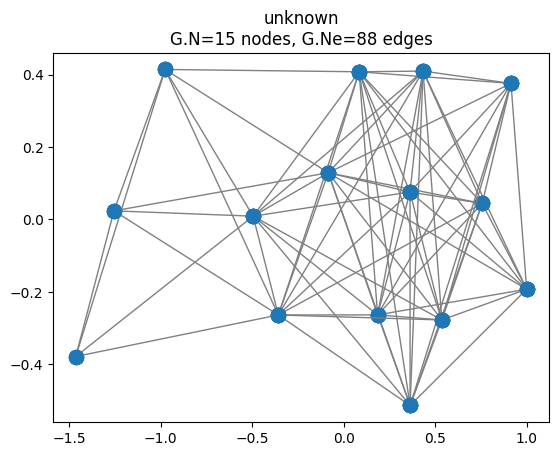

In [25]:
grafo_peso_grayscale(A,1,np.mean(Av))

2024-04-17 19:02:24,861:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


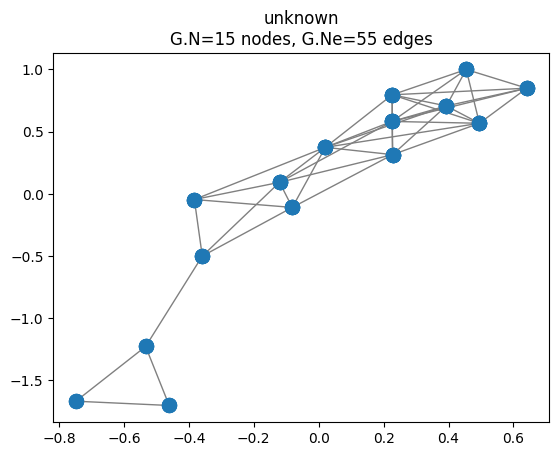

In [26]:
grafo_peso_grayscale(A,1,np.quantile(Av,0.25))

Vendo tabelinhas de grayscale, talvez um bom valor para o $\kappa$ seja de 10 a 20, idealmente 15.

## Teste dos Filtros com sinais diferentes

A filtragem é basicamente fazer $$UHU^t f$$, onde $f$ é o final

In [27]:
n = 10 
M = np.ones((n,n)) # nossa imagem 
M_rand = np.random.rand(n,n)
q = np.quantile(M_rand.reshape(100,1),0.25)

2024-04-17 19:02:50,006:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


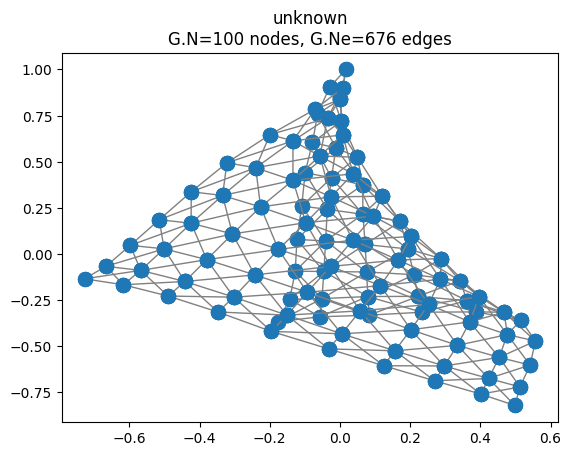

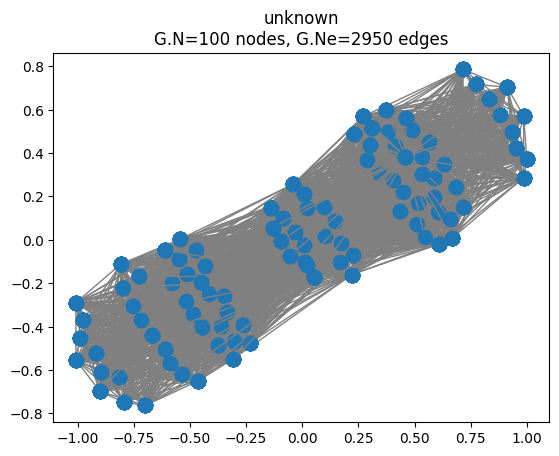

In [29]:
G_M = grafo_img_simples(M)
G_M_rand = grafo_peso_grayscale(M_rand,1,q)

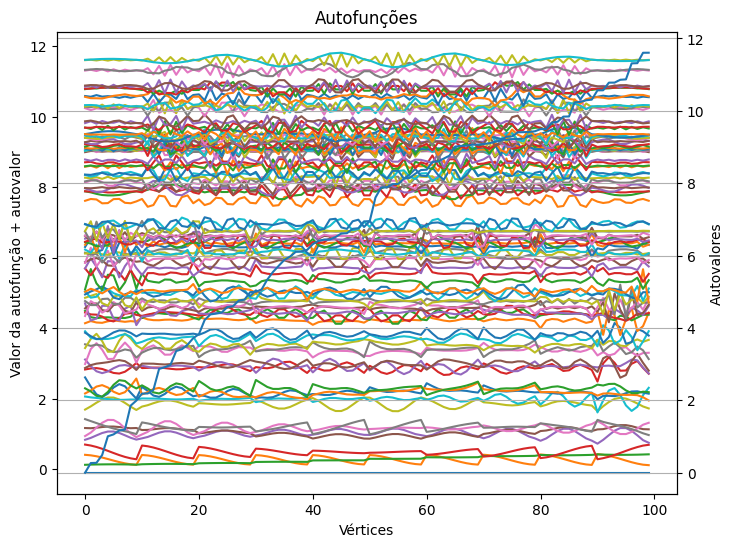

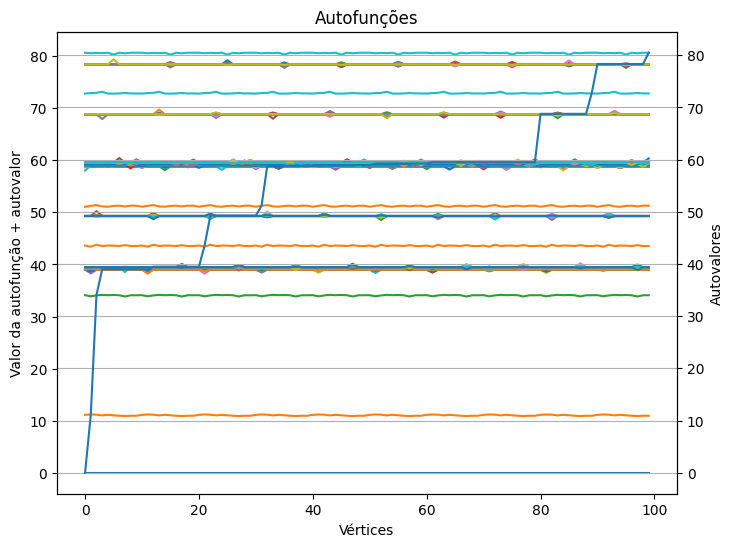

In [30]:
U = autofuncoes(G_M,True,True)
U_rand = autofuncoes(G_M_rand,True,True)

### Filtragem !

In [31]:
H_heat = heat(G_M.e)
H_tik = tikhonov(G_M.e)

H_rand_heat = heat(G_M_rand.e)
H_rand_tik = tikhonov(G_M_rand.e)

In [32]:
f1 = np.ones(n*n)
f2 = M_rand.reshape((1,100))

f1_ruido = f1 + np.random.normal(0,1,n*n)
f2_ruido = f2 + np.random.normal(0,1,n*n)

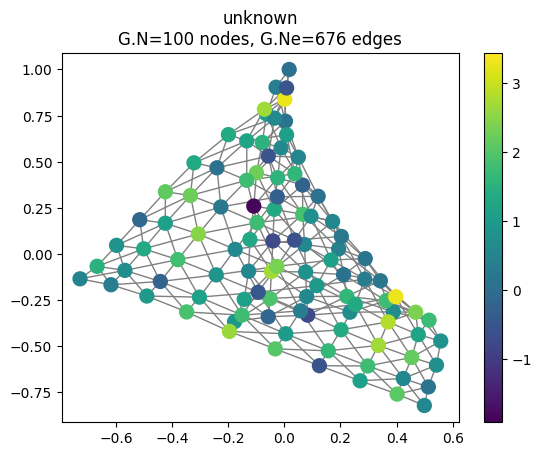

In [33]:
G_M.plot_signal(f1_ruido)

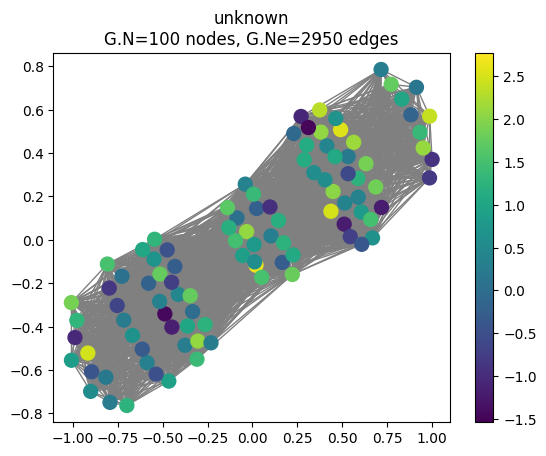

In [34]:
G_M_rand.plot_signal(f2_ruido)

In [35]:
f1_heat = U@H_heat@U.T@f1_ruido
f1_tik = U@H_tik@U.T@f1_ruido

f2_heat = U_rand@H_rand_heat@U_rand.T@f2_ruido.T
f2_tik = U_rand@H_rand_tik@U_rand.T@f2_ruido.T

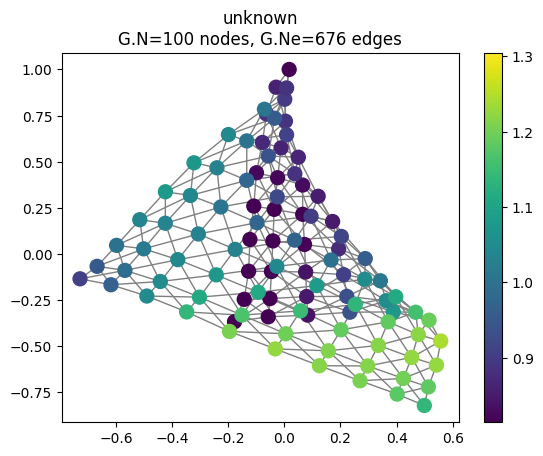

In [36]:
G_M.plot_signal(f1_heat)

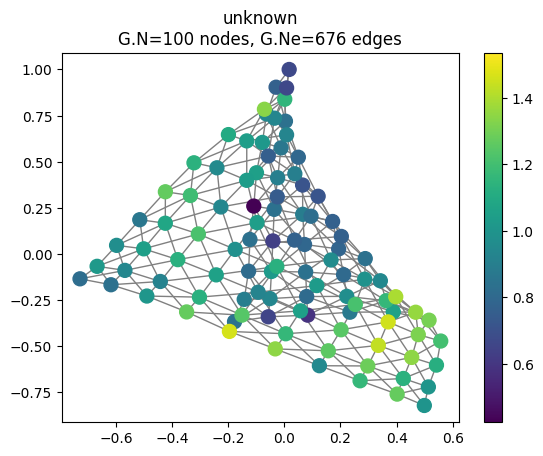

In [37]:
G_M.plot_signal(f1_tik)

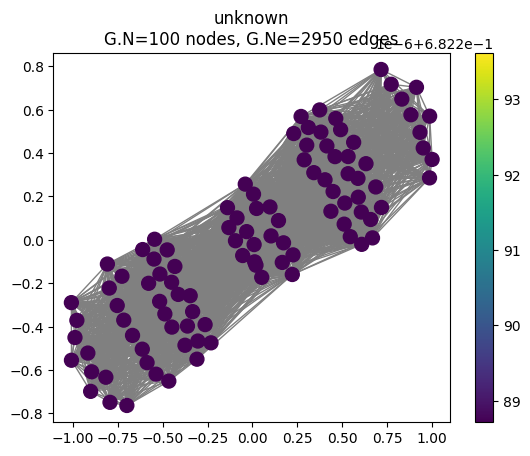

In [38]:
G_M_rand.plot_signal(f2_heat)

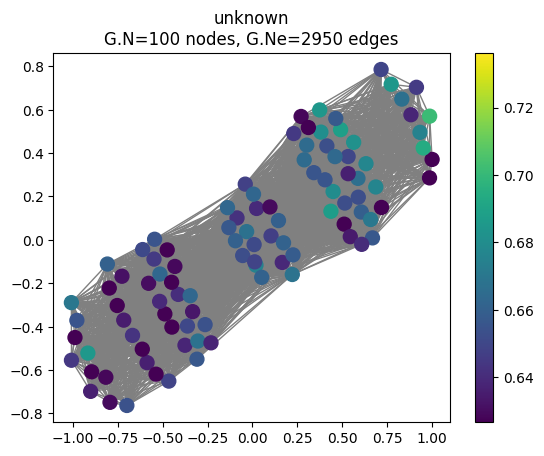

In [39]:
G_M_rand.plot_signal(f2_tik)

## Métricas de Teste

Agora que temos os grafos, os sinais e os filtros, vamos testá-los de alguma maneira. As propostas são:

* Erro quadrático médio
* Peak signal-to-noise ratio

In [40]:
def MSE(original,filtrado):
    '''Calcula o erro quadrático médio da filtração escolhida.
    
    Parâmetros:
    - original (array): sinal original, sem ruídos, para usar como
    referência no MSE
    - filtrado (array): sinal obtido com a filtração
    
    Returns:
    - mse (float): erro quadrático médio'''

    soma = sum((original - filtrado)**2) # soma dos quadrados 
    n = len(filtrado)
    mse = soma/n
    return mse

In [41]:
def PSNR(original,filtrado,img=True):
    '''Calcula o Peak signal-to-noise ratio com relação a alguma fltração
    escolhida. O PSNR é a variação relativa do máximo valor possível
    do sinal em relação ao erro quadrático médio (norma L2 do erro),
    em escala logarítmica.
    
    Parâmetros:
    - original (array): sinal original
    - filtrado (array): sinal filtrado de acordo com a filtração de 
    escolha
    
    Returns: 
    - res (float): medida do PSNR'''
    mse = MSE(original,filtrado) # precisa dessa métrica
    if img:
        max_f = 255
    else: 
        # definindo uma métrica alternativa para meu toy problem
        max_f = max(filtrado)
    res = 20*np.log10(max_f) - 10*np.log10(mse)
    return res

In [43]:
mse_heat = MSE(f1,f1_heat)
mse_tik = MSE(f1,f1_tik)

psnr_heat = PSNR(f1,f1_heat)
psnr_tik = PSNR(f1,f1_tik)

print(f'   Filtro   |     MSE     |     PSNR    ')
print(f'------------------------------------------')
print(f' Heat  | {mse_heat} | {psnr_heat} ')
print('-------------------------------------------')
print(f'Tikhonov | {mse_tik} | {psnr_tik} ')

   Filtro   |     MSE     |     PSNR    
------------------------------------------
 Heat  | 0.01962147886774355 | 65.20348623884317 
-------------------------------------------
Tikhonov | 0.04482101941202413 | 61.61598630936111 


## Outros Testes 

agora vou brincar com os gráficos e afins, já acabou a implementação

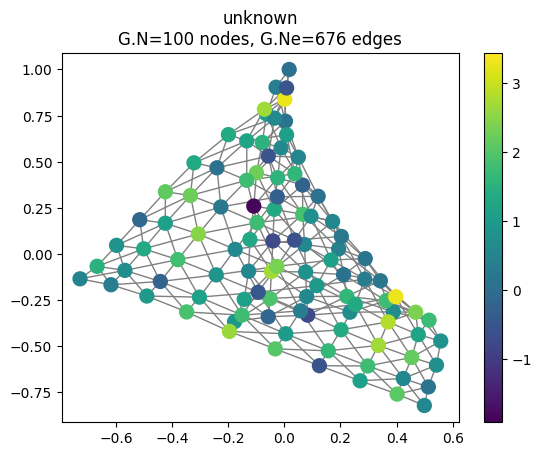

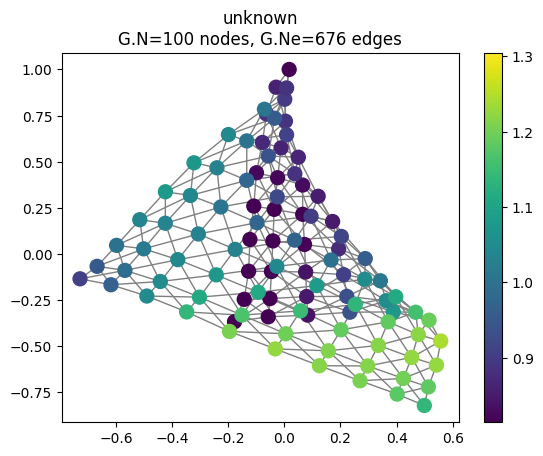

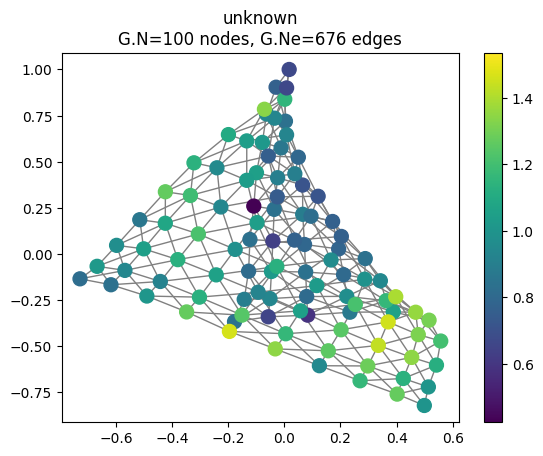

In [47]:
#fig, ax = plt.subplots(ncols=3,figsize=(10,4))

G_M.plot_signal(f1_ruido)
G_M.plot_signal(f1_heat)
G_M.plot_signal(f1_tik)
